# Notes

This notebook contains cleaned-up code for R1 activity phase plotting.

It combines code from: R1_Activity_Plots.ipynb and R1_Compare_Search_Methods.ipynb

It uses data stored in JSON format and created using: R1_Load_Data.ipynb



# Imports

In [1]:
import json
import numpy as np
from astropy.timeseries import TimeSeries as ts
from matplotlib import pyplot as plt
from astropy.time import Time
from astropy import units as u
from scipy.signal import lombscargle as ls
import astropy
from astropy.modeling import models, fitting

# Functions

In [2]:
#Kenzie Nimmo's ChiSq code:

def chisq(N,exp):
    """
    N = binned number of bursts
    exp = exposure time per bin
    """
    p=float(np.sum(N)/np.sum(exp))

    E = np.zeros_like(N)
    for binno in range(len(N)):
        E[binno] = p*exp[binno]
    
    chisq_stat=np.sum((N-E)**2/(E))
    
    return chisq_stat


def folding(beginp,endp,bins,burst_times,begin_times,end_times):
    """
    beginp and endp are the beginning and end trial periods to fold in days
    bins is an integer number of bins to divide your period into
    burst_times is an array of the observation days which contains a burst
    begin_times is an array of the observation begin times with AND without bursts
    end_times is an array of the observation end times with AND without bursts
    """
    freqs=np.arange(1./float(endp),1./float(beginp),(1./float(bins))/(np.max(burst_times)-np.min(burst_times)))
    #print(freqs)
    periods = np.sort(1./freqs) #days
    #print(periods)
    
    #fig=plt.figure(figsize=(4,3))
    #ax=fig.add_subplot(111)
    #ax.plot(periods,marker='o',label='periods')
    #ax.plot(freqs,marker='o',label='frequencies')
    #ax.legend()
    #plt.show()
    
    t0=begin_times.min()
    tend=end_times.max()

    chisq_values=[]
    ps=[]
    #for pind,p in enumerate(tqdm(periods)): #removed tqdm for now
    for pind,p in enumerate(periods):
        bin_length= p/float(bins) #days
        binned=np.zeros(bins)
        exposure=np.zeros(bins)
        for i in range(int(np.ceil((tend-t0)/bin_length))): #chop up into bins
            if i==0:
                begin_time = t0 + i*bin_length
            else: begin_time = end_time
            end_time = begin_time + bin_length
            above=np.where(burst_times >= begin_time) 
            below=np.where(burst_times < end_time )
            count=len(np.intersect1d(above,below)) #find the bursts within the begin_time and end_time of the bin
            binned[(i)%bins]+=count #adding a count each time a burst falls in a particular bin
            # compute the exposure
            time_before=np.where(begin_times < end_time)
            time_after=np.where(end_times > begin_time)
            overlap_with_bin=np.intersect1d(time_before,time_after)
            for over in range(len(overlap_with_bin)):
                if begin_times[overlap_with_bin[over]] <= begin_time:
                    begin_exp = begin_time
                else: begin_exp = begin_times[overlap_with_bin[over]]
                if end_times[overlap_with_bin[over]] >= end_time:
                    end_exp = end_time
                else: end_exp = end_times[overlap_with_bin[over]]
            exp = ((end_exp-begin_exp)*24.*3600.) 
            exposure[(i)%bins]+=exp #adding exposure per bin in seconds 
        #print(chisq(binned,exposure))
        chisqp=float(chisq(binned,exposure))/(bins-1)
        chisq_values.append(chisqp)
        ps.append(p)
    return chisq_values, ps

def TallyBursts(ObservingTimes,ObservingDurations,BurstMJDs):
    """
    For papers which provide burst data but not observing information, we must find the observing 
    files where these bursts were stored on dop263.
    
    The bursts must then be tallied into their respective observations. This function does this.
    
    INPUTS:
    
    ObservingTimes     : [array of astropy mjd values] List of observation start times which
                         contained bursts. Must be calculated from observing data.
    ObservingDurations : [array of astropy seconds values] List of observation durations in u.s.
                         Must be calculated from observing data.
    BurstMJDs          : [array of floats] List of mjd values of the bursts observed. Must NOT
                         be an astropy time quantity.
    
    
    RETURNS:
    
    TalliedEvents : [array of ints of shape equal to list of observing times]
    """
    
    
    TalliedEvents = np.zeros_like(ObservingTimes)

    #print(TalliedEvents)
    for i in range(len(BurstMJDs)): #loop over marcote bursts
        for j in range(len(ObservingTimes)): #loop over observation start times
            if (Time(BurstMJDs[i],format='mjd') > ObservingTimes[j]) & (Time(BurstMJDs[i],format='mjd') < ObservingTimes[j] + ObservingDurations[j]): #if burst falls into obs
                #print(True)
                TalliedEvents[j]+=1 #tally burst
    if np.sum(TalliedEvents) != len(BurstMJDs):
        print('warning! Not all bursts are tallied. Code is wrong.')
    else:
        print('bursts tallied.')
        
    return TalliedEvents

# Load data from JSON files

In [3]:
########################
#load L and C-band data#
########################

jsonfile = 'AnyBand_R1.json' #the file containing the data
#jsonfile = 'LBand_R1.json' #the file containing the data


with open(jsonfile, 'r') as f: #open file
    r1_data = json.load(f) #load all data

#print keys (i.e. data) for reference
print('Data Keys: {0}\n'.format(r1_data.keys())) 


###################################################
#extract keys I will use to filter or process data#
###################################################

burst_dict = r1_data['bursts'] #mjds of bursts
tel_dict = r1_data['obs_tels'] #telescopes of observtions
freq_dict = r1_data['obs_freqs'] #frequencies of observations
dura_dict = r1_data['obs_duration'] #duration of all observations
start_dict = r1_data['obs_startmjds'] #strt mjds of all observations
bpo_dict = r1_data['bursts_per_obs'] #detected events in each observation

#print keys (i.e. particular observing setups) for reference
print('Setup keys: {0}\n'.format(burst_dict.keys())) 

Data Keys: dict_keys(['bursts', 'obs_duration', 'obs_startmjds', 'bursts_per_obs', 'obs_tels', 'obs_freqs', 'references'])

Setup keys: dict_keys(['Cruces21a', 'Hardy17a', 'Houben19a', 'ALFA16a', 'Scholtz16a', 'Hewitt22a', 'Scholtz17a', 'Jahns22a', 'Marcote16a', 'MAGIC17a', 'Rajwade20a', 'Oostrum17a', 'CalebMeerKAT20a', 'CalebSardinia20a', 'CalebNancay20a', 'Michilli18a', 'Spitler18a', 'Gaijar18a', 'CalebEffelsberg20a'])



# Extract only bursts to be processed

In [21]:
##################################################################
#construct a data filter (e.g. select only L-band Arecibo bursts)#
##################################################################

#choose filter inputs
minfreq_filter = 4 #[GHz] #inlude bursts detected in bands above this min freq
maxfreq_filter = 8 #[GHz] #include bursts detected in bands below this max freq
telescope_filter = ['Nancay']#['Effelsberg','Nancay',Sardinia','Arecibo','Lovell','GBT','WSRT','MeerKAT'] #telescopes of choice to include data from
telescope_filter = ['Nancay','Effelsberg','Nancay','Sardinia','Arecibo','Lovell','GBT','WSRT','MeerKAT'] #telescopes of choice to include data from


#####################################################################################
#loop over all burst data and extract only data from setups which comply with filter#
#####################################################################################

#initialise arrays to hold bursts (and corresponding data) to use
bursts_to_use = [] #mjds of bursts
bpos_to_use = [] #events per observation
duras_to_use = [] #observation durations [s]
starts_to_use = [] #observation start mjds
#burstfreqs_to_use = [] #observing frequencies for bursts being used

#pick out bursts to use from all bursts
for k in burst_dict.keys(): #loop over data
    
    print('Telescope: {0}'.format(tel_dict[k]))
    print('Frequency: {0} GHz'.format(freq_dict[k]))
    
    #construct data filter from filter inputs
    data_filter = ((freq_dict[k]>minfreq_filter)&(freq_dict[k]<maxfreq_filter))&(np.isin(tel_dict[k],telescope_filter))
    print('Filter passed: {0}'.format(data_filter))
    
    #select only data which passes filter
    if data_filter==True:
        
        #store selected data to their arrays
        print(burst_dict[k])
        bursts_to_use += burst_dict[k]  #burst mjds
        bpos_to_use += bpo_dict[k] #events per observation
        duras_to_use += dura_dict[k] #observation durations [s]
        starts_to_use += start_dict[k] #start mjds of observations
        #burstfreqs_to_use += freq_dict[k]
        #print(freq_dict[k])
    
print('bursts to use: {0}'.format(bursts_to_use))
#print('freqs of these bursts: {0}'.format(burstfreqs_to_use))

Telescope: Effelsberg
Frequency: 1.36 GHz
Filter passed: False
Telescope: Effelsberg
Frequency: 1.4 GHz
Filter passed: False
Telescope: Effelsberg
Frequency: 1.4 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 1.7 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: False
Telescope: Lovell
Frequency: 1.4 GHz
Filter passed: False
Telescope: WSRT
Frequency: 1.4 GHz
Filter passed: False
Telescope: MeerKAT
Frequency: 1.4 GHz
Filter passed: False
Telescope: Sardinia
Frequency: 0.336 GHz
Filter passed: False
Telescope: Nancay
Frequency: 1.486 GHz
Filter passed: False
Telescope: Arecibo
Frequency: 4.5 GHz
Filter passed: True
[57747.1295649013, 57747.1371866766, 57747.1462

# Set period to use for folding

In [22]:
#set Cruces+21 -derived period
Cruces_p = 161 #[days]

# Begin

## Create astropy phase plots

### Simple phase plot

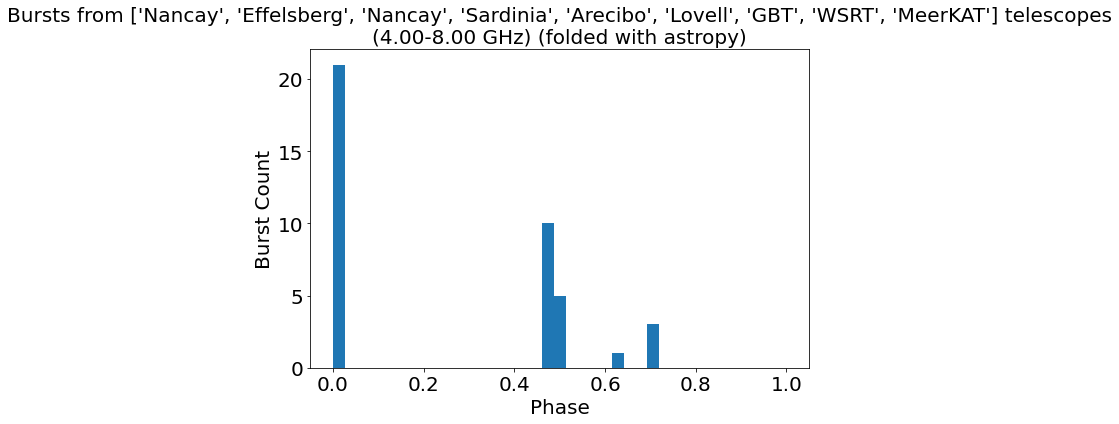

In [23]:
#choose bins
bins = np.linspace(0,1,40)

#fold with astropy
all_ts = ts(time=Time(bursts_to_use,format='mjd')) #convert to astropy timeseries

#fold over Cruces+21 period
#Note: potentially make epoch_time = the start time of the first observation. 
#This will allow us to line up events phase plot with observations phase plot.

all_ts_folded = all_ts.fold(period=Cruces_p*u.day)

#turn into phase
all_phase = (all_ts_folded.time.jd-np.min(all_ts_folded.time.jd))/Cruces_p

#plot
fig = plt.figure(figsize=(8,6))
ax1=fig.add_subplot(111)
ax1.set_title('Bursts from {0} telescopes\n({1:.2f}-{2:.2f} GHz) (folded with astropy)'.format(telescope_filter,minfreq_filter,maxfreq_filter),fontsize=20)
ax1.set_xlabel('Phase',fontsize=20)
ax1.set_ylabel('Burst Count',fontsize=20)
ax1.tick_params(axis='x',labelsize=20)
ax1.tick_params(axis='y',labelsize=20)

ax1.hist(all_phase,bins=bins)
plt.tight_layout()
plt.show()

### Weighted phase plot

/tmp/ipykernel_2979/2719452784.py:67: RuntimeWarning: divide by zero encountered in true_divide
  ax3.bar(obsphase_bins[:-1] + np.diff(obsphase_bins) / 2, burstphase_cnts/obsphase_cnts, np.diff(bins))
/tmp/ipykernel_2979/2719452784.py:67: RuntimeWarning: invalid value encountered in true_divide
  ax3.bar(obsphase_bins[:-1] + np.diff(obsphase_bins) / 2, burstphase_cnts/obsphase_cnts, np.diff(bins))


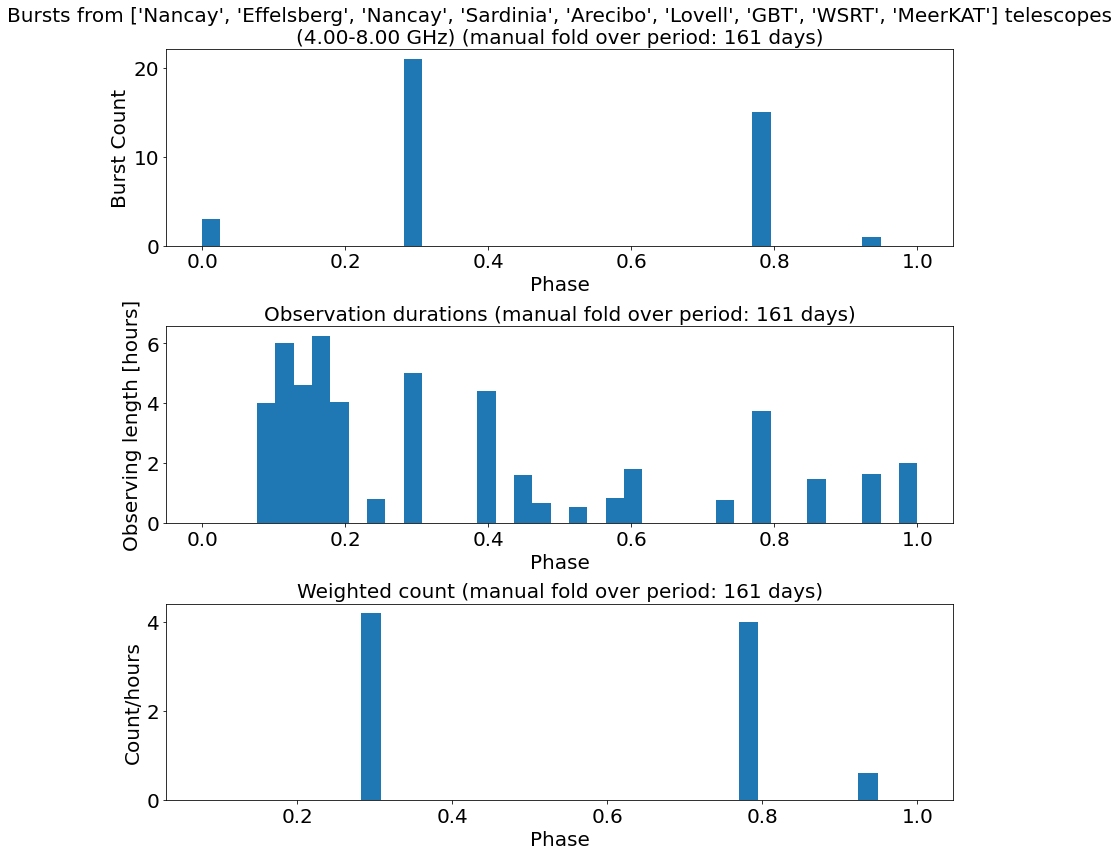

In [24]:
#get the phase data manually

#choose bins
bins = np.linspace(0,1,40)

#initial time of first observation
data_t0 = Time(np.min(bursts_to_use),format='mjd')
#print(data_t0)

#arrival times after first observation 
data_burst_tarr = (Time(bursts_to_use,format='mjd')-data_t0).value
#print(data_burst_tarr)

#times of observations after first observation
data_obs_tarr = (Time(starts_to_use,format='mjd')-data_t0).value
#print(data_obs_tarr)

#burst arrival times as a function of phase according to Cruces+21 period
burst_phase = (data_burst_tarr/Cruces_p)-(data_burst_tarr//Cruces_p) 

#observing times as a function of phase according to Cruces+21 period
obs_phase = (data_obs_tarr/Cruces_p)-(data_obs_tarr//Cruces_p)

#observing lengths corresponding to these times/phases
obs_len = (duras_to_use*u.s).to(u.hr).value #convert from seconds to hours


#plot
fig = plt.figure(figsize=(12,12))
ax1=fig.add_subplot(311)
ax1.set_title('Bursts from {0} telescopes\n({1:.2f}-{2:.2f} GHz) (manual fold over period: {3} days)'.format(telescope_filter,minfreq_filter,maxfreq_filter,Cruces_p),fontsize=20)
ax1.set_xlabel('Phase',fontsize=20)
ax1.set_ylabel('Burst Count',fontsize=20)
ax1.tick_params(axis='x',labelsize=20)
ax1.tick_params(axis='y',labelsize=20)

burstphase=ax1.hist(burst_phase,bins=bins)

ax2=fig.add_subplot(312)
ax2.set_title('Observation durations (manual fold over period: {0} days)'.format(Cruces_p),fontsize=20)
ax2.set_xlabel('Phase',fontsize=20)
ax2.set_ylabel('Observing length [hours]',fontsize=20)
ax2.tick_params(axis='x',labelsize=20)
ax2.tick_params(axis='y',labelsize=20)

#sum observing lengths according to bins of observing phase
#method from: 
# https://stackoverflow.com/questions/51392433/sum-one-numpy-array-based-on-bins-of-another)
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#i.e.: each value in obs_phase contributes its associated length towards the bin count (instead of 1)

obsphase = ax2.hist(obs_phase,bins=bins,weights=obs_len)

ax3=fig.add_subplot(313)
ax3.set_title('Weighted count (manual fold over period: {0} days)'.format(Cruces_p),fontsize=20)
ax3.set_xlabel('Phase',fontsize=20)
ax3.set_ylabel('Count/hours',fontsize=20)
ax3.tick_params(axis='x',labelsize=20)
ax3.tick_params(axis='y',labelsize=20)

#instructions to get np.histogram to plot like plt.hist here:
# https://stackoverflow.com/questions/46656010/plt-hist-vs-np-histogram-unexpected-results

burstphase_cnts, burstphase_bins = np.histogram(burst_phase,bins=bins)
obsphase_cnts, obsphase_bins = np.histogram(obs_phase,bins=bins,weights=obs_len)

ax3.bar(obsphase_bins[:-1] + np.diff(obsphase_bins) / 2, burstphase_cnts/obsphase_cnts, np.diff(bins))

plt.tight_layout()
plt.show()